# Fraudulent Activities - PART I

### OBJECTIF

Les sites de E-commerce font transiter beaucoup d'argent. Cela peut engendrer des risques non négligeables d'activités frauduleuses, comme l'utilisation de carte de crédit volées, du blanchiment d'argent, etc.

Fort heureusement, le Machine Learning peut nous aider à identifier ces activités frauduleuses. Tous les sites web où vous devez entrer vos informations de paiements ont une équipe qui s'occupe de gérer les risques de fraude via le ML.

Le but de ce challenge est de construire un modèle qui vous permet de prédire une probabilité de transaction frauduleuse.

### DESCRIPTION

L'entreprise X fait du E-commerce et vend des vêtements faits-main. Votre but est de construire un modèle qui permette de prédire si l'achat d'un vêtement doit être considéré comme une transaction frauduleuse ou non.

Voici précisément ce que vous devez faire :

1. Pour chacun des utilisateurs, déterminez le pays d'origine depuis son adresse IP

2. Construisez un modèle qui permette de prédire si l'activité est frauduleuse ou non. Expliquez aussi vos choix / hypothèses en termes d'optimisation de faux-positifs et faux-négatifs

3. Votre patron aimerait comprendre votre modèle car il est inquiet d'utiliser un modèle _black box_. Comment l'expliqueriez vous d'un point utilisateur, et non pas mathématique. Par exemple, quels sont les utilisateurs qui peuvent être classés comme _risqués_ ?

4. Supposons que vous pouvez utiliser votre modèle en live pour qu'il fasse sa prédiction en temps réel. D'un point de vue Produit, comment l'utiliseriez-vous ? Comment pourriez-vous penser l'expérience utilisateur face à ce produit ?


### DATA

Vous pouvez utiliser les deux tables suivantes :

```python
Fraud_Data
```

&

```python
IpAddress_to_Country
```


In [2]:
# Importing the libraries
import s3fs

import pandas as pd
import numpy as np

import time

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [3]:
# Importing the datasets
df = pd.read_csv("s3://full-stack-bigdata-datasets/Machine Learning Supervisé/projects/fraudulent_activity/Fraud_Data.csv")
ip = pd.read_csv("s3://full-stack-bigdata-datasets/Machine Learning Supervisé/projects/fraudulent_activity/IpAddress_to_Country.csv")

In [4]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


## Adding features

In [7]:
# Converting DateTime features to time stamp
date2convert = ['signup_time', 'purchase_time']
for i in date2convert :
    df[i] = df[i].apply(lambda x: pd.to_datetime(x, format='%Y/%m/%d %H:%M:%S').timestamp())

In [8]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,1.424819e+09,1.429325e+09,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,1.433710e+09,1.433728e+09,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,1.420138e+09,1.420138e+09,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,1.430256e+09,1.430748e+09,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,1.437463e+09,1.441824e+09,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [9]:
# Adding a feature country_name using the IP adresses and 'IP' dataframe
def transform_ip(arg):
    try:
        return ip.country[(ip.lower_bound_ip_address < arg) & (ip.upper_bound_ip_address > arg)].iloc[0]
    except IndexError:
        return "Unknown country"  
      
df["country_name"] = df.ip_address.apply(transform_ip)

In [10]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name
0,22058,1.424819e+09,1.429325e+09,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,1.433710e+09,1.433728e+09,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,1.420138e+09,1.420138e+09,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,1.430256e+09,1.430748e+09,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country
4,221365,1.437463e+09,1.441824e+09,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [11]:
# Identify and remove the countries with less than 10 occurencies 
occurency_countries = df['country_name'].value_counts()

df['rows_to_delete'] = df['country_name'].apply(lambda x : occurency_countries.loc[x])

df = df.loc[df['rows_to_delete'] > 10,:]
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name,rows_to_delete
0,22058,1.424819e+09,1.429325e+09,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,7306
1,333320,1.433710e+09,1.433728e+09,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,58049
2,1359,1.420138e+09,1.420138e+09,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,58049
3,150084,1.430256e+09,1.430748e+09,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country,21966
4,221365,1.437463e+09,1.441824e+09,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,58049


In [12]:
# Removing the index of 'df'
df = df.reset_index(drop=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150869 entries, 0 to 150868
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         150869 non-null  int64  
 1   signup_time     150869 non-null  float64
 2   purchase_time   150869 non-null  float64
 3   purchase_value  150869 non-null  int64  
 4   device_id       150869 non-null  object 
 5   source          150869 non-null  object 
 6   browser         150869 non-null  object 
 7   sex             150869 non-null  object 
 8   age             150869 non-null  int64  
 9   ip_address      150869 non-null  float64
 10  class           150869 non-null  int64  
 11  country_name    150869 non-null  object 
 12  rows_to_delete  150869 non-null  int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 15.0+ MB


In [14]:
df.describe(include = 'all')

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name,rows_to_delete
count,150869.000000,1.508690e+05,1.508690e+05,150869.000000,150869,150869,150869,150869,150869.000000,1.508690e+05,150869.000000,150869,150869.000000
unique,NaN,NaN,NaN,NaN,137739,3,5,2,NaN,NaN,NaN,118,NaN
top,NaN,NaN,NaN,NaN,EQYVNEGOFLAWK,SEO,Chrome,M,NaN,NaN,NaN,United States,NaN
freq,NaN,NaN,NaN,NaN,20,60517,61338,88148,NaN,NaN,NaN,58049,NaN
mean,200165.586827,1.429489e+09,1.434420e+09,36.938702,NaN,NaN,NaN,NaN,33.141533,2.151907e+09,0.093730,NaN,27543.116830
std,115361.968952,5.930636e+06,7.042915e+06,18.323139,NaN,NaN,NaN,NaN,8.617422,1.248734e+09,0.291454,NaN,24989.956616
min,2.000000,1.420070e+09,1.420070e+09,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000,NaN,11.000000
25%,100646.000000,1.424248e+09,1.429366e+09,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085716e+09,0.000000,NaN,3161.000000
50%,199946.000000,1.429416e+09,1.434632e+09,35.000000,NaN,NaN,NaN,NaN,33.000000,2.154366e+09,0.000000,NaN,21966.000000
75%,300040.000000,1.434636e+09,1.439834e+09,49.000000,NaN,NaN,NaN,NaN,39.000000,3.242803e+09,0.000000,NaN,58049.000000


<AxesSubplot:>

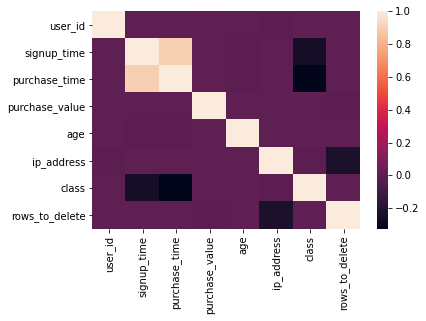

In [15]:
# Displaying the correlation matrix of the dataframe
correlation = df.corr()

sns.heatmap(correlation, 
        xticklabels=correlation.columns,
        yticklabels=correlation.columns)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

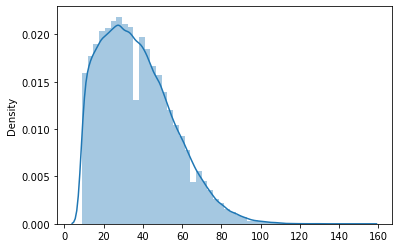

In [16]:
sns.distplot(x=df['purchase_value'])

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

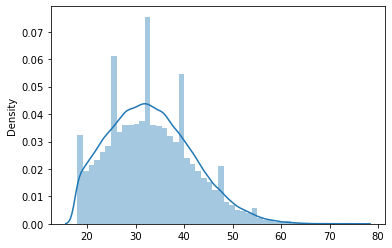

In [17]:
sns.distplot(x=df['age'])

In [18]:
# Spliting features(X) and target(y)
X = df.iloc[:,[1,3,5,6,7,8,11]]
y = df.iloc[:,10]

In [19]:
# Converting those two variables to numpy arrays
X = X.values
y = y.tolist()

In [20]:
# Train Test split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [21]:
# Create pipeline for numeric features
numeric_features = [0,1,5] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

In [22]:
# Create pipeline for categorical features
categorical_features = [2,3,4,6] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [23]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [24]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
...Done.
  (0, 0)	0.10026788500330265
  (0, 1)	0.9845875146700545
  (0, 2)	0.797818068279408
  (0, 4)	1.0
  (0, 8)	1.0
  (0, 26)	1.0
  (1, 0)	1.440047481961973
  (1, 1)	1.5853239241084571
  (1, 2)	0.33382983895136265
  (1, 4)	1.0
  (1, 8)	1.0
  (1, 58)	1.0
  (2, 0)	-1.3274937603553172
  (2, 1)	0.0015642992253953618
  (2, 2)	1.3778033549394648
  (2, 3)	1.0
  (2, 28)	1.0
  (3, 0)	0.8900261199749127
  (3, 1)	0.16540150179950522
  (3, 2)	3.4657503869156696
  (3, 4)	1.0
  (3, 8)	1.0
  (3, 9)	1.0
  (3, 62)	1.0
  (4, 0)	-1.48785263659529
  (4, 1)	2.295285135262933
  (4, 2)	-0.36215250504070556
  (4, 4)	1.0
  (4, 6)	1.0
  (4, 122)	1.0

Performing preprocessings on test set...
...Done.
  (0, 0)	-1.3326108241929169
  (0, 1)	2.4045099369790064
  (0, 2)	-1.174131906364785
  (0, 4)	1.0
  (0, 9)	1.0
  (0, 14)	1.0
  (1, 0)	-0.9077512965285502
  (1, 1)	-1.36374572222552
  (1, 2)	-0.36215250504070556
  (1, 8)	1.0
  (1, 9)	1.0
  (1, 123)	1.0
  (2, 0)	0.528697838

## KNN

##### KNN default parameters (baseline)

In [30]:
# Trainning KNN model on the train set
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [54]:
# printing the f1 score for the model
print("f1-score on train set : ", f1_score(y_train, knn.predict(X_train)))
print("f1-score on test set : ", f1_score(y_test, knn.predict(X_test)))

f1-score on train set :  0.6366448542534205
f1-score on test set :  0.6208461230481783


In [53]:
# scores recap
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     41019
           1       0.72      0.55      0.62      4242

    accuracy                           0.94     45261
   macro avg       0.83      0.76      0.79     45261
weighted avg       0.93      0.94      0.93     45261



##### KNN with optimized parameters

In [25]:
# Using GridSearchCV to optimize the parameters 
param_grid_knn = {'n_neighbors':[3,5,7],
                 'metric':['euclidean','manhattan']}

grid_knn = GridSearchCV(KNeighborsClassifier(),param_grid_knn, cv = 5)

In [26]:
# Using GridSearchCV to optimize the parameters
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7]})

In [27]:
grid_knn = grid_knn.best_estimator_

In [49]:
# Predictions on training set with best_estimators_
print("Predictions on training set...")
Y_train_pred = grid_knn.predict(X_train)
print("...Done.")
# F1 score calculation
print("f1-score on train set : ", f1_score(y_train, grid_knn.predict(X_train)))

# Predictions on test set with best_estimators_
print("Predictions on test set...")
Y_test_pred = grid_knn.predict(X_test)
print("...Done.")
# F1 score calculation
print("f1-score on test set : ", f1_score(y_test, grid_knn.predict(X_test)))

Predictions on training set...
...Done.
f1-score on train set :  0.6847264302263412
Predictions on test set...
...Done.
f1-score on test set :  0.6316067653276956


In [52]:
# scores recap
print(classification_report(y_test, grid_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     41019
           1       0.72      0.56      0.63      4242

    accuracy                           0.94     45261
   macro avg       0.84      0.77      0.80     45261
weighted avg       0.93      0.94      0.94     45261



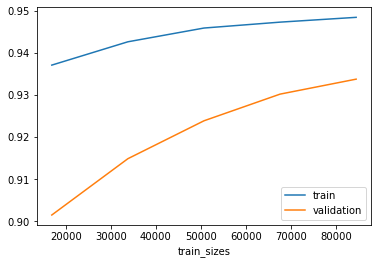

In [29]:
N, train_score, val_score = learning_curve(grid_knn, X_train, y_train, 
                                           train_sizes = np.linspace(0.2, 1.0, 5), cv=5)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

##### It seems that the KNN model gives the best ressult. According to the learning curve the result could
##### even improve with more data.

## Random Forest

##### Random Forest with optimized parameters

In [25]:
max_depth = [1, 2, 3, 4]
min_samples_split = [2, 5, 10]
n_estimators = np.arange(20,50,5)

rf_grid = GridSearchCV(estimator=RandomForestClassifier(), cv=5,
                       param_grid={"max_depth":max_depth, 
                                   "min_samples_split":min_samples_split,
                                   "n_estimators":n_estimators},
                      verbose=2)

rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] max_depth=1, min_samples_split=2, n_estimators=20 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=1, min_samples_split=2, n_estimators=20, total=   0.3s
[CV] max_depth=1, min_samples_split=2, n_estimators=20 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=1, min_samples_split=2, n_estimators=20, total=   0.4s
[CV] max_depth=1, min_samples_split=2, n_estimators=20 ...............
[CV]  max_depth=1, min_samples_split=2, n_estimators=20, total=   0.4s
[CV] max_depth=1, min_samples_split=2, n_estimators=20 ...............
[CV]  max_depth=1, min_samples_split=2, n_estimators=20, total=   0.4s
[CV] max_depth=1, min_samples_split=2, n_estimators=20 ...............
[CV]  max_depth=1, min_samples_split=2, n_estimators=20, total=   0.3s
[CV] max_depth=1, min_samples_split=2, n_estimators=25 ...............
[CV]  max_depth=1, min_samples_split=2, n_estimators=25, total=   0.5s
[CV] max_depth=1, min_samples_split=2, n_estimators=25 ...............
[CV]  max_depth=1, min_samples_split=2, n_estimators=25, total=   0.4s
[CV] max_depth=1, min_samples_split=2, n_estimators=25 ...............
[CV]  max_depth=1, min_samples_split=2, n_estimators=25, total=   0.4s
[CV] max_depth=1, min_samples_split=2, n_estimators=25 ...............
[CV]  

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  4.2min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': array([20, 25, 30, 35, 40, 45])},
             verbose=2)

In [26]:
print("Hyperparameters that give the best score : ", rf_grid.best_params_)
print("Best score : ", rf_grid.best_score_)

print("...Done.")

Hyperparameters that give the best score :  {'max_depth': 4, 'min_samples_split': 10, 'n_estimators': 25}
Best score :  0.9062844359749782
...Done.


In [48]:
rf = RandomForestClassifier(max_depth=rf_grid.best_params_['max_depth'],
                           min_samples_split=rf_grid.best_params_['min_samples_split'],
                           n_estimators=rf_grid.best_params_['n_estimators'])
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, min_samples_split=10, n_estimators=25)

In [49]:
rf = rf_grid.best_estimator_

In [50]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = rf.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = rf.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [53]:
print("f1-score on train set : ", f1_score(y_train, rf.predict(X_train)))
print("f1-score on test set : ", f1_score(y_test, rf.predict(X_test)))

f1-score on train set :  0.0
f1-score on test set :  0.0


In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     41019
           1       0.00      0.00      0.00      4242

    accuracy                           0.91     45261
   macro avg       0.45      0.50      0.48     45261
weighted avg       0.82      0.91      0.86     45261



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic regression 

In [37]:
from sklearn.linear_model import LogisticRegression

logisticreg = LogisticRegression()
logisticreg.fit(X_train, y_train) # model estimate
y_pred = logisticreg.predict(X_train) # model predictions

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
print("f1-score on train set : ", f1_score(y_train, logisticreg.predict(X_train)))
print("f1-score on test set : ", f1_score(y_test, logisticreg.predict(X_test)))

f1-score on train set :  0.0050342327829238824
f1-score on test set :  0.005172819186456619


In [55]:
print(classification_report(y_test, logisticreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     41019
           1       1.00      0.00      0.01      4242

    accuracy                           0.91     45261
   macro avg       0.95      0.50      0.48     45261
weighted avg       0.92      0.91      0.86     45261

